##  1. Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta


##  2. Load and Prepare Data

In [109]:
df = pd.read_csv('../../Data/final/sales_forecast_data.csv')
df['SalesDate'] = pd.to_datetime(df['SalesDate'])
df = df.sort_values(by=['StoreID', 'ItemID', 'SalesDate'])


##  3. Feature Engineering

In [110]:
df['DayOfWeek'] = df['SalesDate'].dt.dayofweek
df['DayOfMonth'] = df['SalesDate'].dt.day
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


##  4. Define Target and Features

In [111]:
target_col = 'SalesQuantity'
feature_cols = ['Lag_1', 'Lag_7', 'RollingAvg_7', 'Month', 'DayOfWeek', 
                'DayOfMonth', 'IsWeekend']

X = df[feature_cols]
y = df[target_col]


##  5. Train-Test Split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

##  8. Train XGBoost Model

In [113]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=10
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

import pickle

# Save the model to a .pkl file using pickle
with open('../../artifacts/models/sales_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the model to a .pkl file using pickle
with open('../../WebApp/models/sales_model.pkl', 'wb') as f:
    pickle.dump(model, f)

##  9. Predictions & Evaluation

In [114]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.9914
Root Mean Square Error: 1.3993
R² Score: 0.2323


### Explanation of metrics:
**SalesQuantity Statistics Recap**
- Count: 70,830 rows
- Mean: 12.06
- Std: 10.63
- Min: 3.00
- 25%: 6.00
- 50% (Median): 11.00
- 75%: 12.00
- Max: 48.00

### 1. Mean Absolute Error (MAE: 0.9914)
- **Meaning**: Predictions deviate by approximately 0.99 units of SalesQuantity on average.
- **Implication**: Good performance on typical days (6-12 units) but may miss larger spikes (near 48)

### 2. Root Mean Square Error (RMSE: 1.3993)
- **Meaning**: Higher than MAE, indicating some larger prediction errors
- **Implication**: Model struggles with outliers/high-sales events (30-48 range)

### 3. R² Score (0.2323)
- **Meaning**: The model explains approximately 23.23% of the variance in sales.
- **Implication**: Missing critical explanatory variables for high-sales days

**Strengths & Limitations**
- Model performs well for average conditions.
- Struggles with extreme values, which inflate RMSE due to squared error weighting
- Model likely underpredicts high-sales events in the 30-48 range

##  10. Plot Predictions vs Actual (First 100 Days)

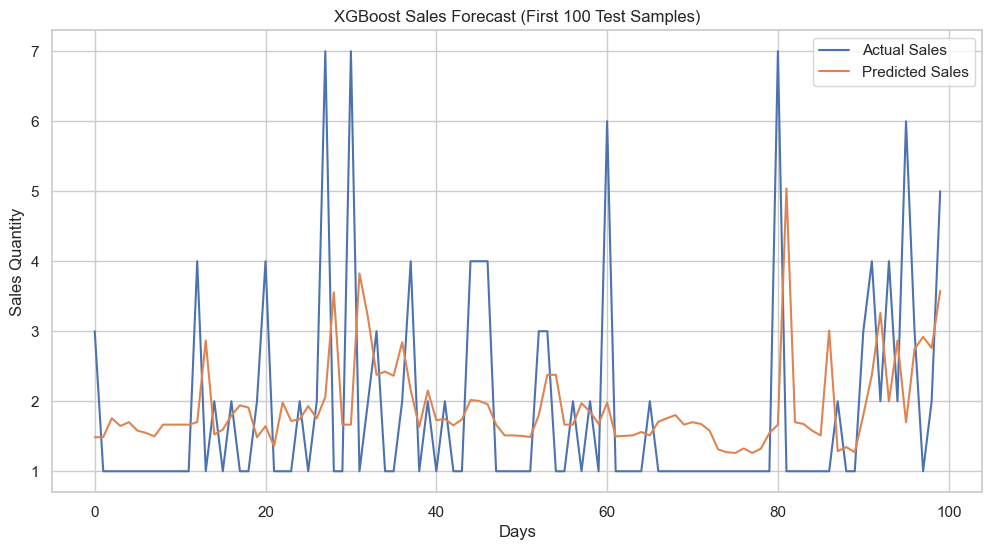

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100].values, label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.title("XGBoost Sales Forecast (First 100 Test Samples)")
plt.xlabel("Days")
plt.ylabel("Sales Quantity")
plt.legend()
plt.savefig('../../artifacts/plots/sales_forecast_first100_plot.png')
plt.show()
